# Preferential sampling models
This notebook demonstrates the models that implement preferential sampling. I load the data, then run the model with the simple ICAR spatial model, then with the ICAR model and preferential sampling.

In [1]:
import warnings
warnings.filterwarnings('ignore')
# For data manipulation
import numpy as np
import geopandas as gpd
import pandas as pd
from matplotlib import pyplot as plt
from libpysal.weights import Rook

# For modeling
import pymc as pm
import arviz as az

%config InlineBackend.figure_format = 'retina'
az.style.use("arviz-darkgrid")

In [2]:
count_data = gpd.read_file('../preprocessed_data/durham_july_2021/durham_july_2021_census_tract.shp')

# Obtain the adjacency matrix
w = Rook.from_dataframe(count_data)
adj = w.to_sparse().todense()

# create temperature as a masked array, so PyMC treats missing values properly
temp = np.ma.array(count_data['eve_avg'], mask=np.isnan(count_data['eve_avg']))

# Required for Preferential Sampling adjustment
counts = count_data['num_statio'].values
population = count_data['population'].values / 1000

# Model 1
This model just looks at temperature with a spatial process.

In [3]:
# Used the the PyMC model
coords = {
    "tract": count_data.index.values
}

# Set initial values
init_val = (temp - temp.mean())
init_val = init_val.filled(0)
init_val = init_val / init_val.std()

In [4]:
with pm.Model(coords=coords) as m1:
    sigma = pm.InverseGamma('sigma', 0.001, 0.001) 
    eps = pm.InverseGamma('eps', mu=0.1, sigma=0.1, dims=("tract",))
    mu = pm.Normal('mu', mu = temp.mean(), sigma = 2)
    phi = pm.ICAR('phi', W=adj, initval=init_val)

    # Likelihood
    T_est = mu + phi * np.sqrt(sigma)
    T = pm.Normal('temp', T_est, sigma = np.sqrt(eps), observed=temp, dims=("tract"))

# Run MCMC
with m1:
    trace_1 = pm.sample(1000, chains=1, random_seed=42)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [sigma, eps, mu, phi, temp_unobserved]


Sampling 1 chain for 1_000 tune and 1_000 draw iterations (1_000 + 1_000 draws total) took 22 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks


If you want to look at convergence, you can run more chains in the cell above and look at the trace results. We note fairly good convergence in our models.

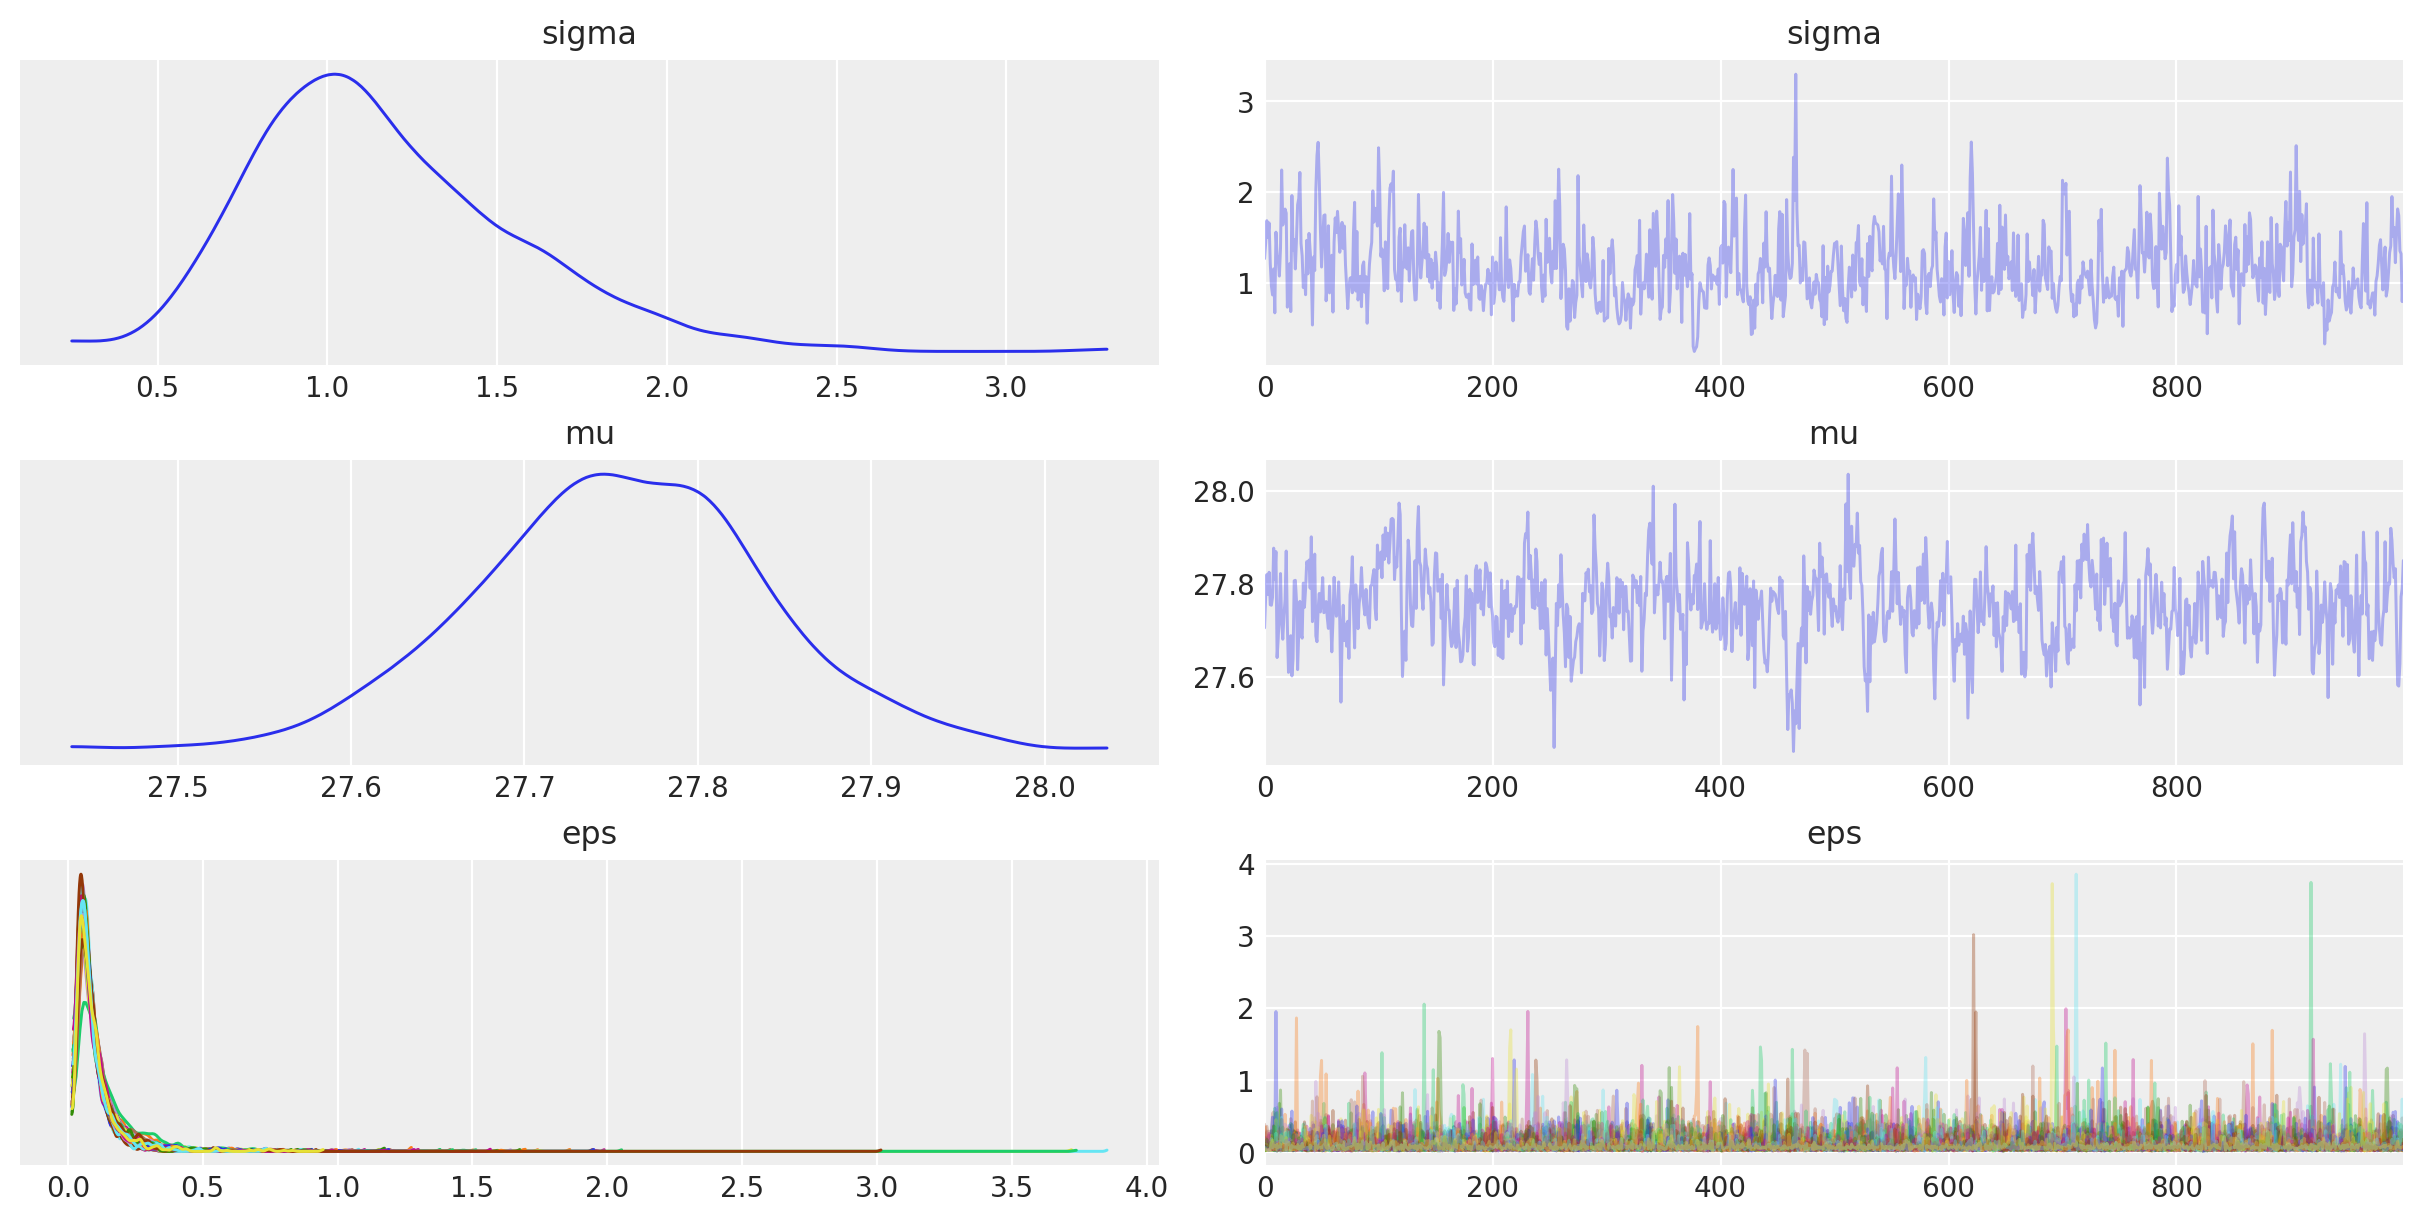

In [5]:
az.plot_trace(trace_1, var_names=['sigma', 'mu', 'eps'])
plt.show()

In [6]:
az.summary(trace_1, var_names=['sigma',  'mu'])#, 'temp'])['ess_bulk'].min()

arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
sigma,1.170,0.390,0.536,1.930,0.026,0.019,212.0,414.0,NaN
mu,27.754,0.085,27.599,27.915,0.006,0.004,206.0,323.0,NaN


Sampling: [temp_observed]


<Axes: >

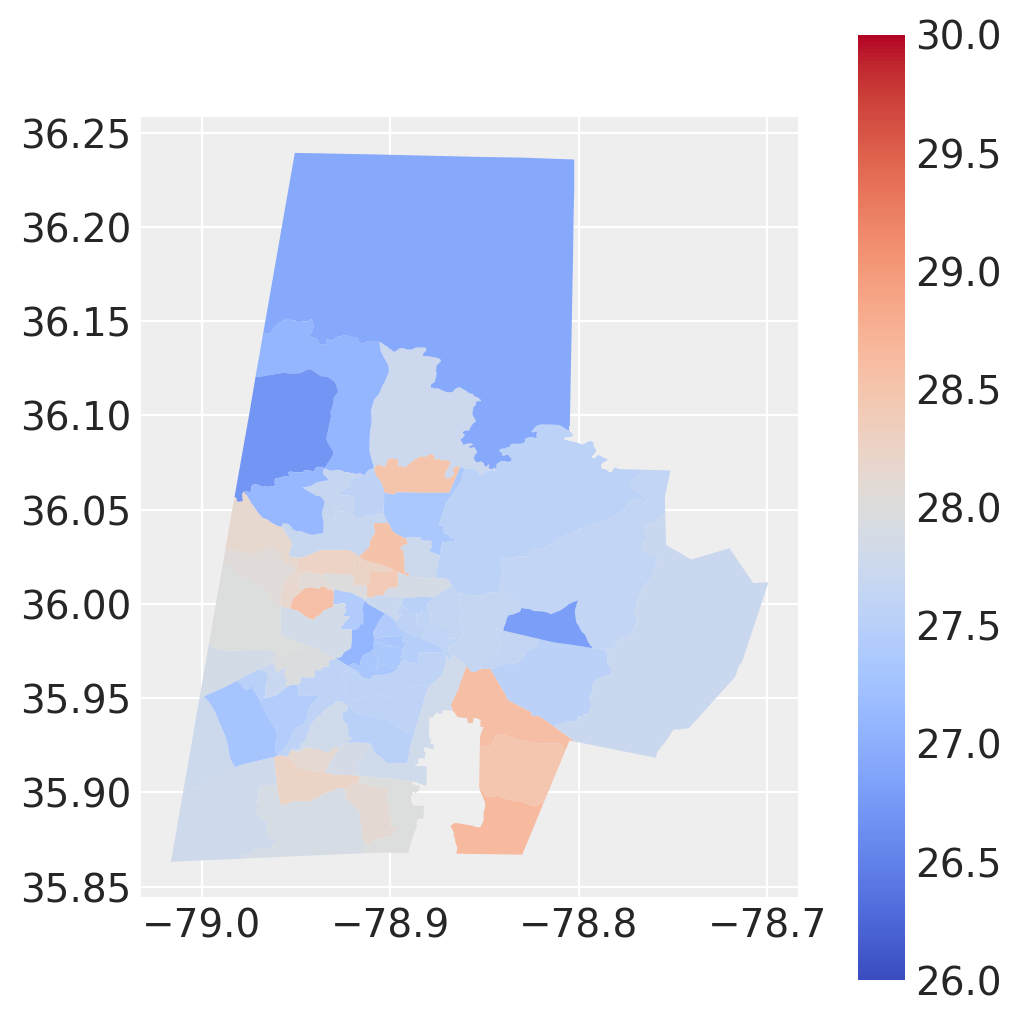

In [7]:
# Sample the posterior predictive results and show

with m1:
    ppc = pm.sample_posterior_predictive(trace_1, var_names=['temp'])
count_data['m1_temp'] = ppc.posterior_predictive['temp'].mean(axis=(0,1)).values
count_data.plot(column='m1_temp', legend=True, figsize=(5,5), cmap='coolwarm', vmin=26, vmax=30)

# Model 2
Now, we apply preferential sampling.

In [8]:
with pm.Model(coords=coords) as m2:

    # These are the same as before
    sigma = pm.InverseGamma('sigma', 0.001, 0.001, initval=1)
    eps = pm.InverseGamma('eps', mu=0.1, sigma=0.1, dims=("tract",))
    mu = pm.Normal('mu', mu = temp.mean(), sigma = 2)
    phi = pm.ICAR('phi', W=adj, initval=init_val)

    # Define the parameters of the Poisson model
    theta_0 = pm.Normal('theta_0', mu = -1, sigma = 1)
    theta_1 = pm.Normal('theta_1', mu=-1, sigma= 1)

    # Likelihood
    T_est = mu + np.sqrt(sigma) * phi
    T = pm.Normal('temp', T_est, sigma = np.sqrt(eps), observed=temp, dims="tract")

    # The Poisson model
    intensity = pm.math.exp(theta_0 + theta_1*phi)
    rates = intensity * population
    lam = pm.Poisson('lam', mu = rates, observed=counts)

    # Sample
    trace_2 = pm.sample(1000, tune=1000, chains=1, random_seed=42)#, target_accept=0.9)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [sigma, eps, mu, phi, theta_0, theta_1, temp_unobserved]


Sampling 1 chain for 1_000 tune and 1_000 draw iterations (1_000 + 1_000 draws total) took 26 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks


In [9]:
az.summary(trace_2, var_names=['sigma', 'mu', 'theta_0', 'theta_1'])

arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
sigma,1.200,0.427,0.441,1.951,0.028,0.020,246.0,384.0,NaN
mu,27.940,0.109,27.739,28.158,0.013,0.009,88.0,38.0,NaN
theta_0,-1.355,0.143,-1.602,-1.072,0.009,0.006,252.0,751.0,NaN
theta_1,-0.821,0.386,-1.443,-0.049,0.047,0.033,93.0,44.0,NaN


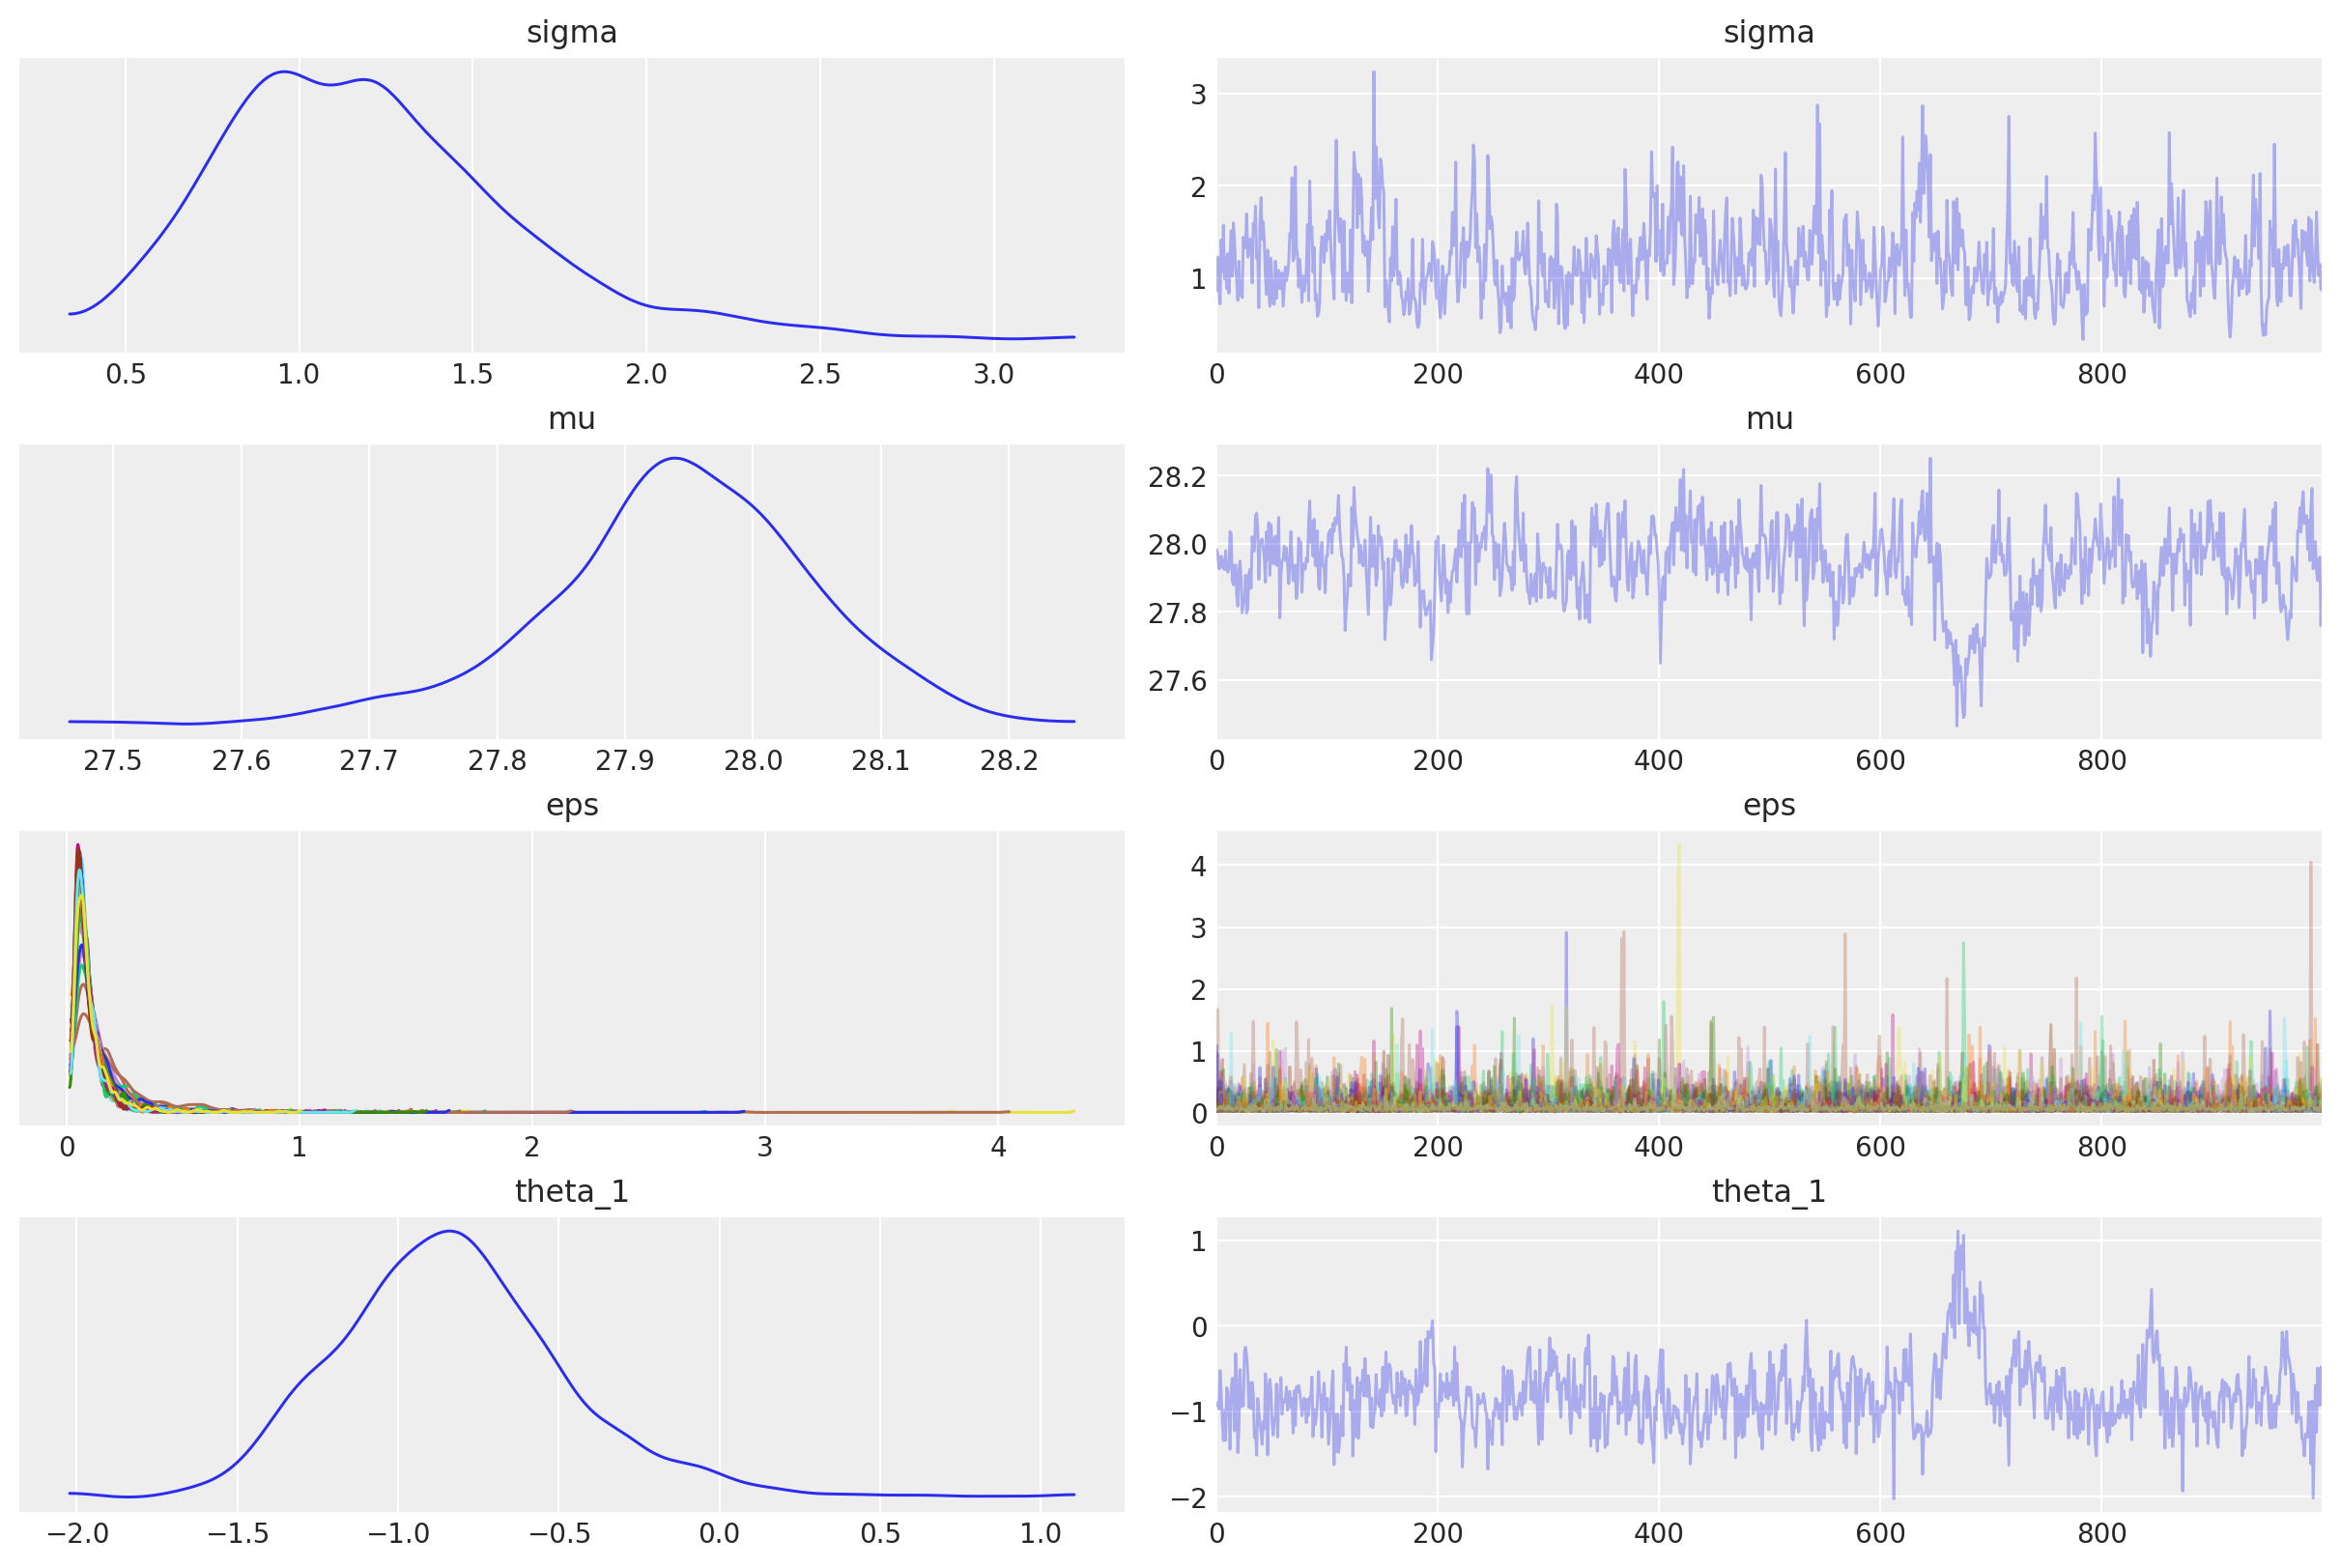

In [10]:
az.plot_trace(trace_2, var_names=['sigma', 'mu', 'eps', 'theta_1'])
plt.show()

Sampling: [temp_observed]


<Axes: >

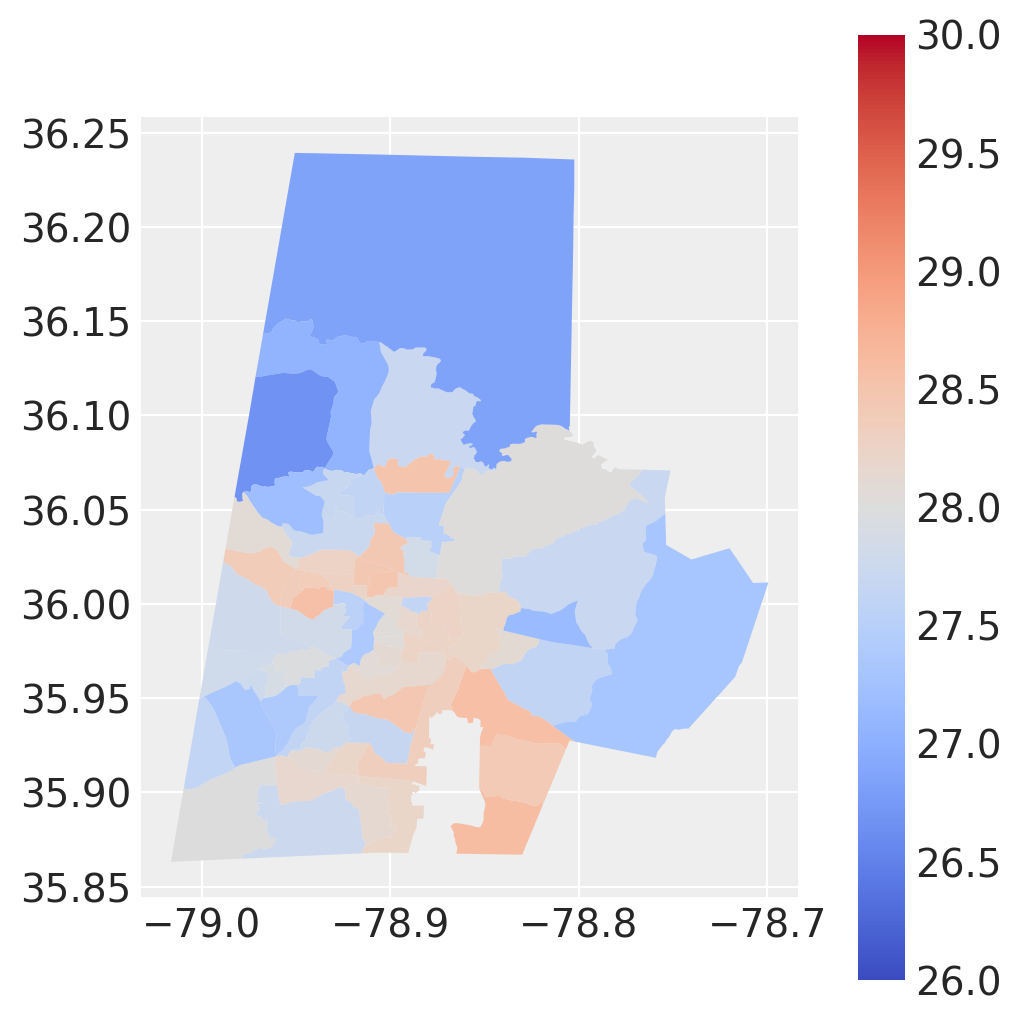

In [11]:
# Save the results of running model 2
with m2:
    ppc = pm.sample_posterior_predictive(trace_2, var_names=['temp'])
count_data['m2_temp'] = ppc.posterior_predictive['temp'].mean(axis=(0,1)).values

# count_data['m2_temp'] = trace_2.posterior['temp'].mean(axis=(0, 1)).values
count_data.plot(column='m2_temp', legend=True, figsize=(5,5), cmap='coolwarm', vmin=26, vmax=30)

When we adjust for preferential sampling, we simply see that the temperature is predicted to be warmer in all of the census tracts where there are no observations.

In [13]:
count_data[['m1_temp', 'm2_temp', 'eve_avg']].mean(axis=0)

m1_temp    27.752564
m2_temp    27.939933
eve_avg    27.776376
dtype: float64

# Model comparison with traversal data

The spatial causal model from the traversal data has already been added to this dataset.

In [12]:
# SCM_temp_dp is the difference between the SCM temperature and the linear confound removed
count_data['no_linear_confound'] = count_data['scm_temp'] - count_data['counfound_']
count_data[['m1_temp', 'm2_temp', 'scm_temp', 'no_unobs', 'no_linear_confound']].corr()

,m1_temp,m2_temp,scm_temp,no_unobs,no_linear_confound
m1_temp,1.000000,0.789040,0.164823,0.247193,0.054606
m2_temp,0.789040,1.000000,0.376002,0.544851,0.430884
scm_temp,0.164823,0.376002,1.000000,0.715078,0.642193
no_unobs,0.247193,0.544851,0.715078,1.000000,0.871508
no_linear_confound,0.054606,0.430884,0.642193,0.871508,1.000000


In [37]:
# Optionally save the results
# cd_w_trav_and_scm.to_file('../results/by_block_group/posterior_predictive_block_group_july2021_eve.shp', index=False)